In [37]:
import pandas as pd
import seaborn as sns

from statsmodels.graphics.correlation import plot_corr
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

In [38]:
dataset = pd.read_csv('pokemon.csv')

In [39]:
dataset.head()

,#,Name,Type,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [40]:
#Odstránime nepotrebné údaje.
del dataset['#']
del dataset['Type2']
del dataset['Name']
del dataset['Total']

#Premenujeme stĺpce pre jednoduchšiu prácu.
dataset.columns = ['Type', 'HP', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed', 'Generation', 'Legendary']

In [41]:
dataset.describe()

,HP,Attack,Defense,SpecialAttack,SpecialDefense,Speed,Generation
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [59]:
#Korelačná matica nám napovie, či existuje korelácia medzi Legendary a štatistikami a teda či je
#možné správne natrénovať sieť. Korelačná metóda pearson využíva štandardný korelačný koeficient.
corrMatrix = dataset.corr( method = 'pearson')
corrMatrix

,HP,Attack,Defense,SpecialAttack,SpecialDefense,Speed,Generation,Legendary
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
SpecialAttack,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
SpecialDefense,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


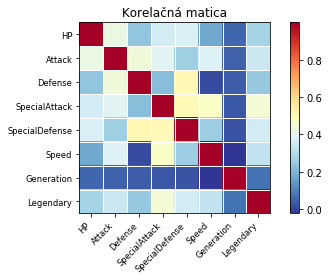

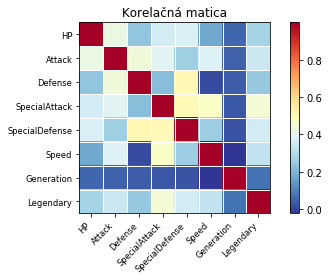

In [43]:
#Môžeme vidieť miernu koreláciu medzi legendárnymi pokémonmi a rýchlosťou útoku/obrany, a rýchlosťou.
plot_corr(corrMatrix, xnames=corrMatrix.columns, ynames=corrMatrix.columns, title='Korelačná matica', cmap='RdYlBu_r')

In [44]:
#Vidíme, že dataset nie je vybalancovaný a existuje veľké množstvo nelegendárnych pokémonov oproti legendárnym.
dataset.Legendary.value_counts()

False    735
True      65
Name: Legendary, dtype: int64

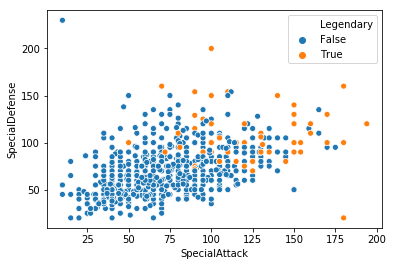

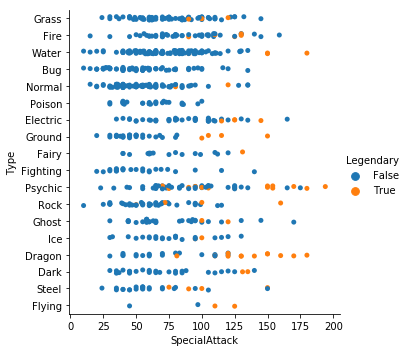

In [45]:
#Na grafoch môžeme vidieť, že  skutočne legendárny pokémoni majú vyššie hodnoty niektorých štatistík.
sns.scatterplot(x='SpecialAttack', y='SpecialDefense', data=dataset,hue="Legendary")
sns.catplot(x='SpecialAttack', y='Type', data=dataset,hue="Legendary")

In [60]:
#Vytvoríme si dataframe do ktorého vložíme všetky stĺpce, ktoré chceme scalovať.
sc_x = dataset[['HP', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed']]
sc_x = sc_x.astype('float')

#Definujeme scaler a vykonáme scalovanie dát.
scaler = StandardScaler()
scaler.fit(sc_x)
scaled_dataset = scaler.transform(sc_x)

In [61]:
#Rozdelíme si dáta na trénovacie a testovacie v pomere 70:30.
X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,dataset['Legendary'],test_size=0.30)

In [73]:
#Definujeme viacvrstvový perceptron a zahájime trénovanie.
MLPC = MLPClassifier(alpha=0.1, hidden_layer_sizes=(1,1), max_iter=1000, random_state=0)
MLPC.fit(X_train, y_train)
prediction = MLPC.predict(X_test)
MLPC.score(X_test, y_test)

0.9166666666666666

In [67]:
confusion_matrix(y_test,prediction)

array([[220,   0],
       [ 20,   0]])

In [68]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96       220
        True       0.00      0.00      0.00        20

   micro avg       0.92      0.92      0.92       240
   macro avg       0.46      0.50      0.48       240
weighted avg       0.84      0.92      0.88       240



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [141]:
#Pomocou triedy GridSearchCV dokážeme zistiť najlepšie parametre pre danú sieť. 
#Funkcia nám vráti nastavenie perceptronu, ktoré získalo najväčšiu presnosť.
from sklearn.model_selection import GridSearchCV

param_grid = [
        {
            'max_iter': [1500],
            'alpha': [0.01],
            'random_state': [0],
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
            (14,),
            (14,1),(14,2),(14,3),(14,4),(14,5),(14,6),(14,7),(14,8),(14,9),(14,10),(14,11),
            (13,1),(13,2),(13,3),(13,4),(13,5),(13,6),(13,7),(13,8),(13,9),(13,10),(13,11),
            (12,1),(12,2),(12,3),(12,4),(12,5),(12,6),(12,7),(12,8),(12,9),(12,10),(12,11),
            (11,1),(11,2),(11,3),(11,4),(11,5),(11,6),(11,7),(11,8),(11,9),(11,10),(11,11),
            (10,1),(10,2),(10,3),(10,4),(10,5),(10,6),(10,7),(10,8),(10,9),(10,10),(10,11)
             ]
        }
       ]

clf = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)
print(clf.best_params_)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimizati

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (14,), 'max_iter': 1500, 'random_state': 0, 'solver': 'adam'}


In [142]:
#Znovu zahájime trénovanie viacvrstvového perceptronu, ktorého parametre sme získali pomocou GridSearchCV knižnice.
#Môžeme vidieť, že zmena parametrov výrazne zvýšila úspešnosť predikcie.
MLPC = MLPClassifier(activation='relu', solver='adam', alpha=0.01, hidden_layer_sizes=(14,), max_iter=1000, random_state=0)
print(MLPC.fit(X_train, y_train))
prediction = MLPC.predict(X_test)
MLPC.score(X_test, y_test)
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(14,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
[[211   9]
 [  3  17]]
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       220
        True       0.65      0.85      0.74        20

   micro avg       0.95      0.95      0.95       240
   macro avg       0.82      0.90      0.86       240
weighted avg       0.96      0.95      0.95       240

